In [1]:
import pickle
import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
infos = []
idx_tups = []
for file in glob.glob("../../data/texas/texas_s*"):
    fd = pickle.load(open(file, 'rb'))
    #print(file, type(infos[-1]))
    var = file.split("_")[-5:]

    if var[-5] == 'std' and ((var[-3] != '0') or (var[-2] != '0')):
        continue
    print(var)
    a, y, m = max([(a, yt - yf, mt  - mf) for a, yt, yf, mt, mf in zip(fd['acc'], fd['yeom_tpr'], fd['yeom_fpr'], fd['merlin_tpr'], fd['merlin_fpr'])])
    fd['accs'] = a
    fd['adv'] = y
    fd['merlin_adv'] = m

    var[-4] = int(var[-4])
    var[-1] = int(var[-1].split(".")[0])
    var[-3] = int(var[-3])
    var[-2] = float(var[-2]) if var[-2] != 'False' else False
    # IDX tups follow the format (epsilon, throw out threshold, batch size)
    idx_tups.append(var)
    infos.append(fd)

['std', '256', '0', '0', '64.b']
['s', '512', '1000', 'False', '64.b']
['s', '256', '50000', 'False', '64.b']
['s', '128', '100000', 'False', '64.b']
['s', '1024', '100000', 'False', '64.b']
['s', '1024', '50000', 'False', '64.b']
['s', '128', '50000', 'False', '64.b']
['std', '128', '0', '0', '64.b']
['s', '512', '10000', 'False', '64.b']
['s', '256', '1000', 'False', '64.b']
['s', '256', '10000', 'False', '64.b']
['s', '1024', '1000', 'False', '64.b']
['std', '512', '0', '0', '64.b']
['s', '512', '100000', 'False', '64.b']
['s', '128', '10000', 'False', '64.b']
['s', '512', '50000', 'False', '64.b']
['s', '128', '1000', 'False', '64.b']
['s', '256', '100000', 'False', '64.b']
['std', '1024', '0', '0', '64.b']
['s', '1024', '10000', 'False', '64.b']


In [3]:
len(infos), len(idx_tups)
infos[0].keys()

dict_keys(['mean_sen', 'min_sen', 'max_sen', 'median_sen', 'std_sen', 'train_l', 'test_l', 'yeom_tpr', 'yeom_fpr', 'acc', 'merlin_tpr', 'merlin_fpr', 'accs', 'adv', 'merlin_adv'])

In [5]:
relevant_vals = sorted([(i[1], i[2], vs) for i, vs in zip(idx_tups, infos)])


means = []
mins = []
maxes = []
medians = []
stds = []
wes = []
train_ls = []
test_ls = []
accs = []
advs = []
l  = len(infos[0]['mean_sen'])



for width, epsilon, i in relevant_vals:
    batches_per_epoch = l // len(i['train_l'])
    means.append(np.array(i['mean_sen']))
    maxes.append(np.array(i['max_sen']))
    mins.append(np.array(i['min_sen']))
    medians.append(np.array(i['median_sen']))
    stds.append(np.array(i['std_sen']))
    train_ls.append(np.array([i['train_l'][j // batches_per_epoch] for j in range(l)]))
    test_ls.append(np.array([i['test_l'][j // batches_per_epoch] for j in range(l)]))
    accs.append(np.array([i['acc'][j // batches_per_epoch] for j in range(l)]))
    advs.append(np.array([i['yeom_tpr'][j // batches_per_epoch] - i['yeom_fpr'][j // batches_per_epoch] for j in range(l)]))
    wes.append((width,epsilon))
    
means = np.array(means).reshape(4, 5, l)
mins = np.array(mins).reshape(4,5,l)
maxes = np.array(maxes).reshape(4,5,l)
medians = np.array(medians).reshape(4,5,l)
stds = np.array(stds).reshape(4,5,l)

train_ls = np.array(train_ls).reshape(4,5,l)
test_ls = np.array(test_ls).reshape(4,5,l)
accs = np.array(accs).reshape(4,5,l)
advs = np.array(advs).reshape(4,5,l)
wes = np.array(wes).reshape(4,5, 2)




#idx_df = pd.DataFrame(relevant_vals)
#idx_df.columns = ['width', 'epsilon']
stacked = np.stack([means, mins, maxes, medians, stds, train_ls, test_ls, accs, advs])
wes

array([[[   128,      0],
        [   128,   1000],
        [   128,  10000],
        [   128,  50000],
        [   128, 100000]],

       [[   256,      0],
        [   256,   1000],
        [   256,  10000],
        [   256,  50000],
        [   256, 100000]],

       [[   512,      0],
        [   512,   1000],
        [   512,  10000],
        [   512,  50000],
        [   512, 100000]],

       [[  1024,      0],
        [  1024,   1000],
        [  1024,  10000],
        [  1024,  50000],
        [  1024, 100000]]])

In [6]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [18]:
smoothed_stack = np.apply_along_axis(lambda x : moving_average(x, 20), 3, stacked)
smoothed_stack.shape

(9, 4, 5, 18721)

In [19]:
mean_stacked = smoothed_stack
mean_stacked.shape

(9, 4, 5, 18721)

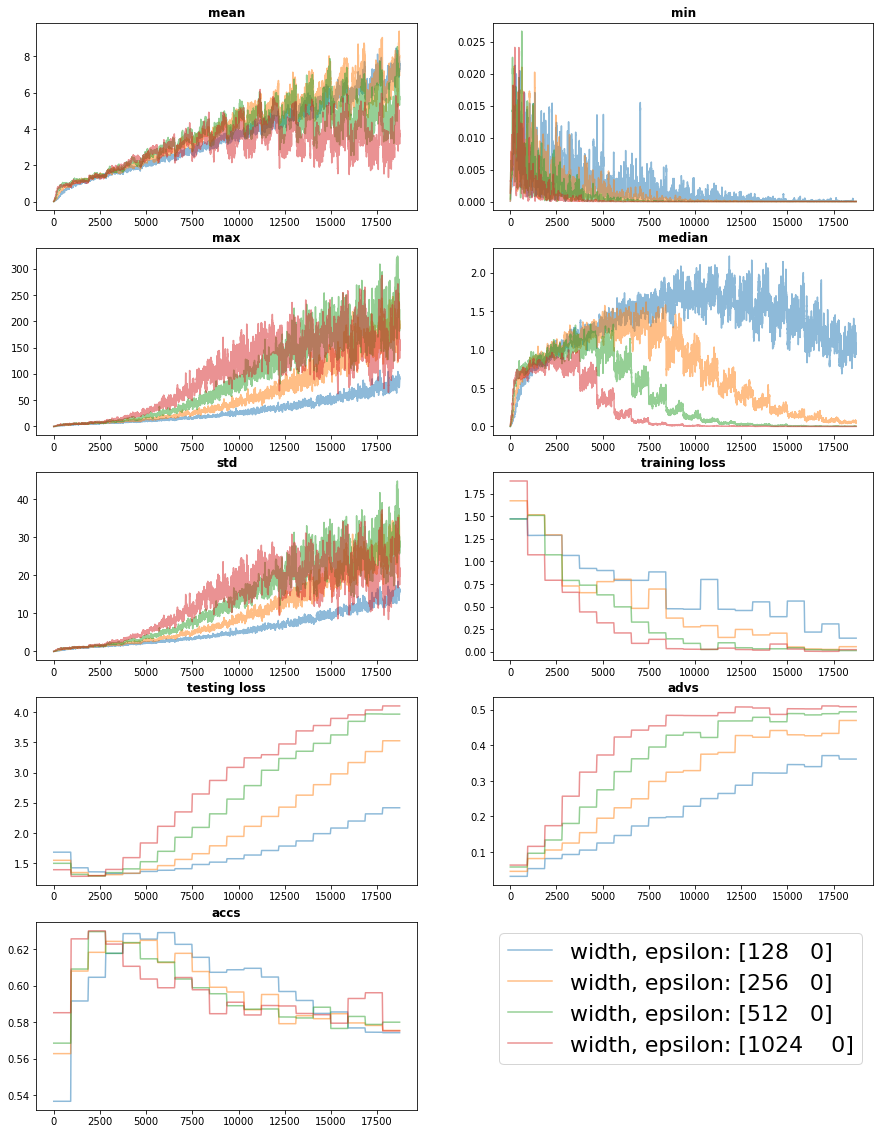

In [20]:
fig, ((ax1, ax2), ( ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(5, 2)
#fig, ((ax3, ax6), (ax7, ax8), (ax9, ax10)) = plt.subplots(3, 2)
fig.set_size_inches(15, 20)


for i in [0, 1, 2, 3]:
    sv = i
    ev = 0
    ax1.plot(mean_stacked[0, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax2.plot(mean_stacked[1, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax3.plot(mean_stacked[2, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax4.plot(mean_stacked[3, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax5.plot(mean_stacked[4, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax6.plot(mean_stacked[5, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax7.plot(mean_stacked[6, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax8.plot(mean_stacked[8, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax9.plot(mean_stacked[7, sv, ev, :], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")
    ax10.plot(mean_stacked[6, sv, ev, 0], alpha=.5, label=f"width, epsilon: {wes[sv, ev, :]}")

ax1.set_title('mean', fontweight='bold')
ax2.set_title('min', fontweight='bold')
ax3.set_title('max', fontweight='bold')
ax4.set_title('median', fontweight='bold')
ax5.set_title('std', fontweight='bold')
ax6.set_title('training loss', fontweight='bold')
ax7.set_title('testing loss', fontweight='bold')
ax8.set_title('advs', fontweight='bold')
ax9.set_title('accs', fontweight='bold')

ax10.axis('off')
ax10.legend(prop={'size': 22})

In [122]:
inf_scalars = [(i[0]['acc'], i[0]['adv'][-1] if type(i[0]['adv']) == list else i[0]['adv'],  i[0]['merlin_adv'][-1][0] if type(i[0]['merlin_adv']) == list else i[0]['merlin_adv'], *i[1]) for i in zip(infos, idx_tups)]
ds = pd.DataFrame(inf_scalars)
ds.columns = ['acc', 'yeom', 'merlin', 'method','width', 'epsilon', 'throw out', 'batch_size']

0 4
0 4
0 4
0 4


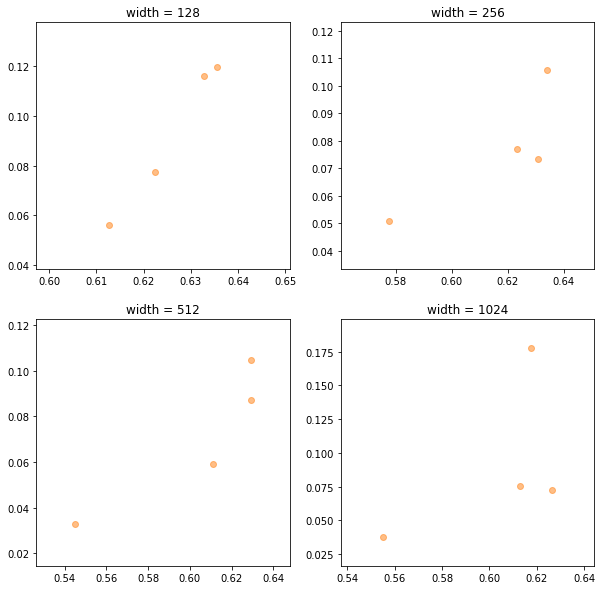

In [124]:
widths = [128, 256, 512, 1024]
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
axes = [ax1, ax2, ax3, ax4]
fig.set_size_inches(10, 10)
for w, ax in zip(widths, axes):
    de = ds[(ds['width'] == w) & (ds['acc'] > .5)]
    dps = de[de['method'] == 'dp']
    iss = de[de['method'] == 'is']
    print(len(dps), len(iss))
    ax.scatter(dps['acc'], dps['yeom'], label='DP',alpha=.5)
    ax.scatter(iss['acc'], iss['yeom'], label='IS', alpha=.5)
    #ax.xlabel('Accuracy')
    #ax.ylabel('Advantage')
    ax.set_title(f'width = {w}')

In [77]:
isacc = ds[ds['method'] == 'is']
isacc.sort_values('acc', ascending=False)[0:50]

,acc,yeom,merlin,method,width,epsilon,throw out,batch_size
14,0.637198,0.097223,0.055469,is,128,10000,False,64
91,0.634320,0.074738,0.056250,is,256,100000,False,64
111,0.632401,0.093585,0.039844,is,256,100000,5,64
63,0.632401,0.101542,0.050000,is,128,100000,5,64
15,0.632401,0.093257,0.194531,is,1024,50000,False,64
53,0.631031,0.067504,0.111719,is,128,50000,5,64
187,0.629523,0.131192,0.139844,is,256,50000,False,64
77,0.628289,0.096866,0.078125,is,128,100000,False,64
3,0.627741,0.118370,0.092969,is,512,100000,False,64
11,0.626096,0.089294,0.128125,is,128,50000,False,64
